# Importing Libraries

In [2]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import requests
from io import BytesIO
import base64
from Binance_API import BinanceAPI
from RiskMetrics import RiskAnalysis, rolling_var,kupiec_test, performance
from PnL_Computation import PnL
from Stock_Data import get_close
from Git import *

In [3]:
# %run "Git.ipynb".ipynb

In [4]:
git=GitHub(token,repo_owner,repo_name,branch)

# Importing Data

## Tickers

In [7]:

Binance=BinanceAPI(binance_api_key,binance_api_secret)
Pnl_calculation=PnL(binance_api_key,binance_api_secret)

In [8]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [10]:
start_date=datetime.datetime(2023,12,1)
enddate=datetime.datetime.today()

In [11]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [12]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [13]:
#trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Trade%20History%20Reconstructed.xlsx'
myfile = requests.get(url)
trade_history=pd.read_excel(BytesIO(myfile.content))
price=Pnl_calculation.get_trade_in_usdt(trade_history)

In [14]:
book_cost=Pnl_calculation.get_book_cost(price)
realized_pnl,profit_and_loss=Pnl_calculation.get_pnl(book_cost,price)
historical_positions=Pnl_calculation.get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [15]:
realized_pnl_time=pd.DataFrame()
for key in profit_and_loss:

    temp=profit_and_loss[key]
    realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)

realized_pnl_time.columns=realized_pnl_time.columns+'USDT'

realized_pnl_time=realized_pnl_time.sort_index().fillna(0)
realized_pnl_time.index=realized_pnl_time.index.strftime(date_format='%Y-%m-%d')
realized_pnl_time.groupby(realized_pnl_time.index).sum()
realized_pnl_time=realized_pnl_time.cumsum()
realized_pnl_time = realized_pnl_time[~realized_pnl_time.index.duplicated(keep='last')]
realized_pnl_time=realized_pnl_time.sum(axis=1)

C:\Users\Admin\AppData\Local\Temp\ipykernel_9572\1326421339.py:5: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  realized_pnl_time=pd.concat([realized_pnl_time,temp],axis=0)


In [16]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [17]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:20].to_list()

In [18]:
holding=Binance.get_inventory()

In [19]:
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
holding_tickers.append('PAXGUSDT')
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.loc['Total','Book Cost']=pnl.loc['Total','Price in USDT']-pnl.loc['Total','Total PnL']
# pnl['Total PnL %']=pnl['Total PnL']/(pnl['Price in USDT']-pnl['Total PnL'])*100
pnl['Total PnL %']=pnl['Total PnL']/(pnl.loc['Total','Book Cost'])*100

pnl.sort_values(ascending=False,by='Price in USDT').round(2)


,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL,Total PnL %
Total,2316.82,2150.54,1.00,-131.89,-34.40,-166.29,-7.18
BTCUSDT,601.02,1049.36,0.49,3.54,448.34,451.88,19.50
SOLUSDT,281.20,333.67,0.16,0.00,52.47,52.47,2.26
ETHUSDT,250.75,258.17,0.12,0.00,7.43,7.43,0.32
JASMYUSDT,387.46,218.76,0.10,0.00,-168.70,-168.70,-7.28
TRXUSDT,76.87,152.75,0.07,-10.72,75.88,65.16,2.81
OMUSDT,526.32,124.09,0.06,0.00,-402.23,-402.23,-17.36
BBUSDT,60.18,12.41,0.01,-39.73,-47.77,-87.50,-3.78
BNBUSDT,1.14,1.32,0.00,-10.61,0.18,-10.43,-0.45
PEPEUSDT,0.00,0.00,0.00,-38.52,-0.00,-38.52,-1.66


In [20]:
days=(enddate-start_date).days
remaining=days%500
numbers_of_table=days//500
remaining

101

In [21]:
# data1=Binance.get_price(tickers,start_date)
# data2=Binance.get_price(tickers,enddate)
# data=data1.combine_first(data2)
# data.index=pd.to_datetime(data.index)
# #data=data.dropna(axis=1)
# n=len(data.columns)
# data=data.sort_index()

In [22]:
temp_end=start_date
prices=pd.DataFrame()
for i in range(numbers_of_table+1):
    temp_data=Binance.get_price(tickers,temp_end)
    temp_end=temp_end+datetime.timedelta(500)
    prices=prices.combine_first(temp_data)
    
temp_end=temp_end+datetime.timedelta(500)
last_data=Binance.get_price(tickers,temp_end)
data=prices.combine_first(last_data)
data=data.sort_index()
data = data[~data.index.duplicated(keep='first')]

In [23]:
data.index=pd.to_datetime(data.index)
n=len(data.columns)
data=data.sort_index()

In [24]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [25]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [26]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [28]:
#position=pd.read_excel('Positions.xlsx',index_col=0)
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Positions.xlsx'
myfile = requests.get(url)
position=pd.read_excel(BytesIO(myfile.content),index_col=0)

positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())
positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)
positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')
git.push_or_update_file(positions,'Positions')

🔁 File exists. Will update (SHA: beee341bc190569af0362c023741713cfebbe388)
✅ File pushed/updated successfully!


In [29]:
positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [30]:
url='https://github.com/niroojane/Risk-Management/raw/refs/heads/main/Quantities.xlsx'
myfile = requests.get(url)
quantities_history=pd.read_excel(BytesIO(myfile.content),index_col=0)
#quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

In [31]:
quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx',index=False)

quantities_tickers=list(quantities.columns)

In [32]:
git.push_or_update_file(quantities,'Quantities')

🔁 File exists. Will update (SHA: 595d0a909ce76b799cc21c83ec8617ed2da066b2)
✅ File pushed/updated successfully!


In [33]:
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])
price_pnl.index=pd.to_datetime(price_pnl.index)

In [34]:
daily_book_cost=book_cost.resample("D").last().dropna().sort_index()

In [35]:
book_cost_history=pd.DataFrame()
book_cost_history.index=set(daily_book_cost.index.append(quantities.index))

book_cost_history=book_cost_history.sort_index()

for col in quantities:
    
    book_cost_history[col]=daily_book_cost[col]

book_cost_history=book_cost_history.ffill()
book_cost_history=book_cost_history.loc[quantities.index]

In [36]:
# pnl_history=pd.DataFrame()
# pnl_history.index=quantities.index
# pnl_history=pnl_history.sort_index()

# for col in quantities:
#     pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

# pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum().values

In [37]:
# pnl_history['Total']

In [38]:
#pnl_history['Total']-pnl_history['Total'].shift(1)

In [39]:
realized_pnl_time2=pd.DataFrame()

realized_pnl_time2.index=quantities.index
realized_pnl_time2=realized_pnl_time2.sort_index()

realized_pnl_time2.index=realized_pnl_time2.index.strftime(date_format='%Y-%m-%d')

    
realized_pnl_time2=pd.concat([realized_pnl_time2,realized_pnl_time])

realized_pnl_time2=realized_pnl_time2.sort_index().fillna(0)
realized_pnl_time2.index=pd.to_datetime(realized_pnl_time2.index)
realized_pnl_time2.groupby(realized_pnl_time2.index).sum()

realized_pnl_time2 = realized_pnl_time2[~realized_pnl_time2.index.duplicated(keep='first')]

realized_pnl_time2.columns=['Realized PnL']

In [40]:
realized_pnl_time2=realized_pnl_time2.fillna(0)

In [41]:
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()

for col in quantities:
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost_history[col])

pnl_history['Total']=pnl_history.sum(axis=1)+realized_pnl_time2['Realized PnL'].loc[quantities.index].cumsum().shift(-1).fillna(0)

In [42]:
pnl_history['Total']

2024-09-23   -242.846960
2024-09-24   -351.229838
2024-09-25   -362.331965
2024-09-26   -276.632747
2024-09-27   -260.113627
                 ...    
2025-07-19   -210.508140
2025-07-20   -114.566409
2025-07-21    -97.892071
2025-07-22    -56.000366
2025-07-23    -23.700055
Name: Total, Length: 304, dtype: float64

<Axes: >

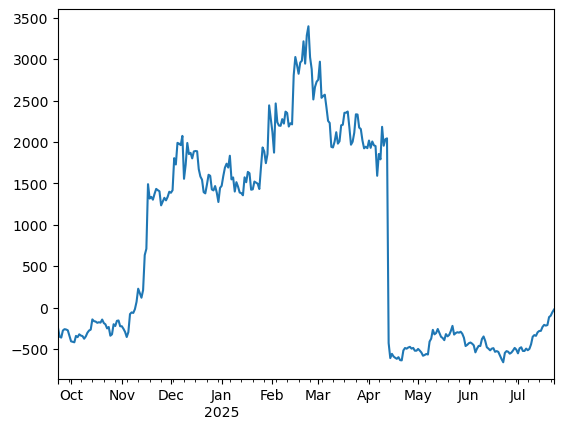

In [43]:
pnl_history['Total'].plot()

In [44]:
daily_pnl=pnl_history['Total']-pnl_history['Total'].shift(1)
daily_pnl.iloc[-29:].cumsum()

2025-06-25     -7.022143
2025-06-26    -30.498499
2025-06-27    -17.676424
2025-06-28      8.045667
2025-06-29     38.873062
2025-06-30     17.589770
2025-07-01    -26.670016
2025-07-02     34.292499
2025-07-03     46.769121
2025-07-04      2.062713
2025-07-05      2.012540
2025-07-06     30.488327
2025-07-07     11.168420
2025-07-08     27.286269
2025-07-09     82.109114
2025-07-10    173.596099
2025-07-11    193.867829
2025-07-12    184.849677
2025-07-13    227.261328
2025-07-14    243.629515
2025-07-15    244.938536
2025-07-16    292.282680
2025-07-17    317.338288
2025-07-18    308.413509
2025-07-19    315.109384
2025-07-20    411.051114
2025-07-21    427.725452
2025-07-22    469.617158
2025-07-23    501.917468
Name: Total, dtype: float64

In [45]:
days=0
pnl_timeframe=daily_pnl[-days:]
MtM=Binance.get_inventory().loc['Total']['Price in USDT']
var_amount=np.nanpercentile(pnl_timeframe,1)
var_pct=var_amount/MtM
cvar_amount=pnl_timeframe[pnl_timeframe<var_amount].mean()
cvar_pct=cvar_amount/MtM
var_amount,cvar_amount

(-373.3655415484129, -950.5160328166933)

In [46]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [47]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [48]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [49]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change(fill_method=None))


LDUMAUSDT not retrieved
Total not retrieved


In [50]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [51]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [52]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

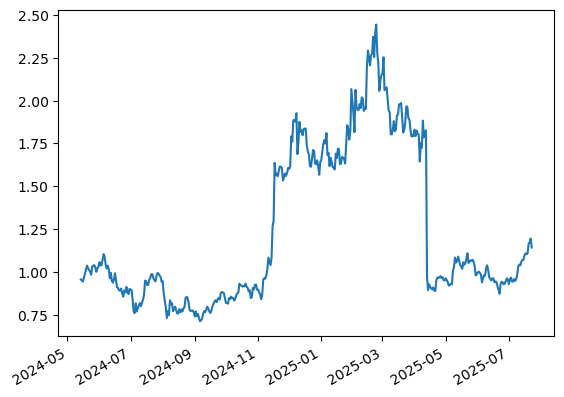

In [53]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()
plt.show()

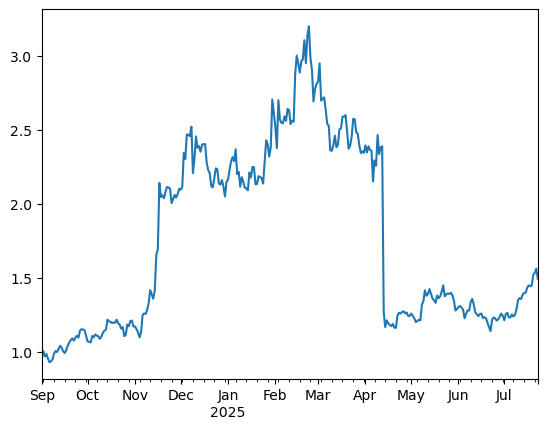

In [54]:
(1+historical_ptf['Historical Portfolio'].loc['2024-09':]).cumprod().plot()
plt.show()

## Ex ante data

In [56]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [59]:
days=0
historical_risk=RiskAnalysis(returns_to_use.iloc[-days:])
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[-days:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [60]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0]#,np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]
gold=np.where(returns_to_use.columns=='PAXGUSDT')[0][0]

## Optimal Portfolio

### Historical results

In [63]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash]-0.00},
                                                                           {'type': 'eq', 'fun': lambda weights: 0.00-weights[gold]}])#,
                                                                              
                                                                              #{'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
BNBUSDT,0.3435
TRXUSDT,0.1640
XRPUSDT,0.1208
ADAUSDT,0.0975
WBTCUSDT,0.0947
BTCUSDT,0.0795
OMUSDT,0.0535
PEPEUSDT,0.0238
SUIUSDT,0.0228
ETHUSDT,0.0000


In [64]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.0},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[gold]},
                                                                          {'type': 'ineq', 'fun': lambda weights: 0.0-weights[cash]}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']
inventory

,Optimal Weights
BNBUSDT,0.328297
WBTCUSDT,0.301344
TRXUSDT,0.167854
XRPUSDT,0.144252
OMUSDT,0.041990
SUIUSDT,0.013285
PEPEUSDT,0.002979


In [65]:
tickers_frontier=holding_tickers.copy()
tickers_frontier.extend(list(inventory.index))
tickers_frontier.remove('BBUSDT')

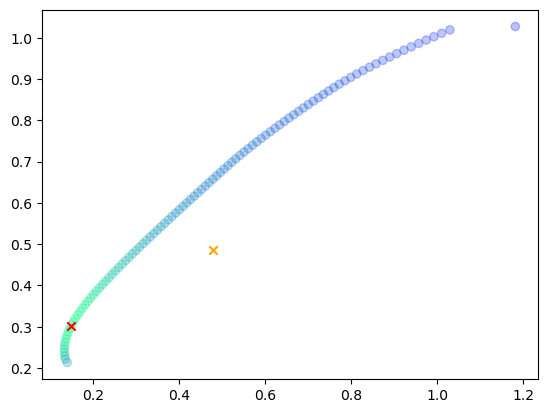

In [66]:
returns_frontier=returns_to_use[tickers_frontier].copy().iloc[-days:]
frontier_analysis=RiskAnalysis(returns_frontier)
current_weights_frontier=np.zeros(returns_frontier.shape[1])
current_weights_frontier[:current_weights.shape[0]]=current_weights
frontier_opt_weights=frontier_analysis.optimize(objective='sharpe_ratio')
X,Y,Z,C=frontier_analysis.efficient_frontier()
opt_res=frontier_analysis.performance(frontier_opt_weights),frontier_analysis.variance(frontier_opt_weights)
current_res=frontier_analysis.performance(current_weights_frontier),frontier_analysis.variance(current_weights_frontier)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()

In [67]:
dico={returns_frontier.columns[i]:frontier_opt_weights[i].round(4) for i in range(len(returns_frontier.columns))}
dico=pd.DataFrame(dico.values(),index=dico.keys(),columns=['Optimal Weights'])

In [68]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,dico],axis=1)
historical_comparison=historical_comparison.fillna(0)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison=historical_comparison.round(7)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1049.363258,0.487954,0.0354,0.452554
SOLUSDT,333.666976,0.155155,0.0000,0.155155
ETHUSDT,258.172512,0.120050,0.0000,0.120050
JASMYUSDT,218.758621,0.101723,0.0000,0.101723
TRXUSDT,152.751713,0.071030,0.0221,0.048930
OMUSDT,124.090535,0.057702,0.0053,0.052402
BBUSDT,12.409540,0.005770,0.0000,0.005770
BNBUSDT,1.323858,0.000616,0.0397,-0.039084
PEPEUSDT,0.000003,0.000000,0.0035,-0.003500
PAXGUSDT,0.000000,0.000000,0.7659,-0.765900


### Current results

In [70]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

gold_current=np.where(ex_ante_perf_to_use.columns=='PAXGUSDT')[0][0]

In [71]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: 0.00-weights[gold_current]}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
BTCUSDT,0.689888
TRXUSDT,0.310112


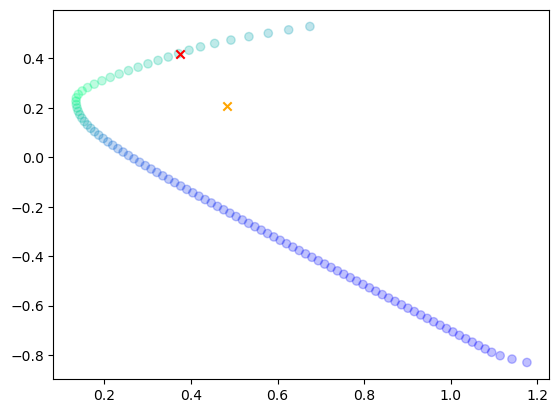

In [72]:
X,Y,Z,C=current_risk.efficient_frontier()

opt_res=current_risk.performance(current_optimal_weights),current_risk.variance(current_optimal_weights)
current_res=current_risk.performance(current_weights),current_risk.variance(current_weights)

plt.scatter(Z,Y,c=C,cmap="winter",alpha=0.25,marker='o')
plt.scatter(opt_res[1],opt_res[0],c='red',marker='x')
plt.scatter(current_res[1],current_res[0],c='orange',marker='x')
plt.show()


In [73]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison=current_holding_comparison.round(7)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
BTCUSDT,1049.363258,0.487954,0.689888,-0.201934
SOLUSDT,333.666976,0.155155,0.000000,0.155155
ETHUSDT,258.172512,0.120050,0.000000,0.120050
JASMYUSDT,218.758621,0.101723,0.000000,0.101723
TRXUSDT,152.751713,0.071030,0.310112,-0.239082
OMUSDT,124.090535,0.057702,0.000000,0.057702
BBUSDT,12.409540,0.005770,0.000000,0.005770
BNBUSDT,1.323858,0.000616,0.000000,0.000616
PEPEUSDT,0.000003,0.000000,0.000000,0.000000


# Risk Reward Analysis

In [75]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [76]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

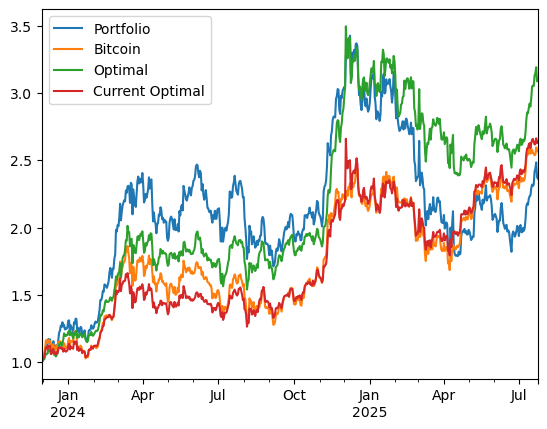

In [77]:
days=0
(1+portfolio_perf.iloc[-days:]).cumprod().plot()
plt.show()

In [78]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

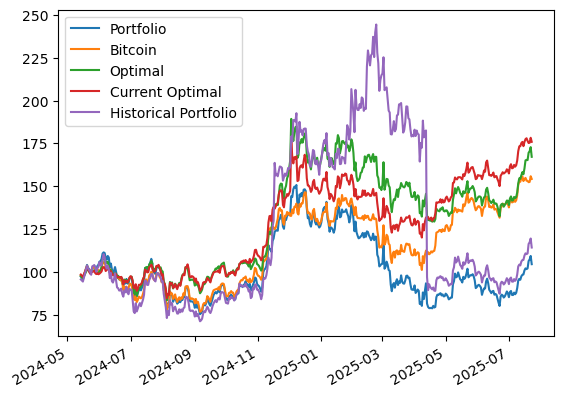

In [79]:
days=0
((1+current_perf.iloc[-days:]).cumprod()*100).plot()
plt.show()


In [80]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2025-07-14,98.288346,155.747224,158.216455,175.869908,106.911464
2025-07-15,98.487503,153.016207,156.981206,173.380597,107.015321
2025-07-16,100.849224,154.145558,160.350566,175.867478,109.508251
2025-07-17,102.057786,154.854851,165.064805,177.472605,110.825050
2025-07-18,101.613173,153.218498,165.381632,177.980078,110.373211
2025-07-19,102.018769,153.108227,165.224010,176.486078,110.739058
2025-07-20,106.333897,152.359464,169.538974,175.215055,116.302117
2025-07-21,107.275512,152.509118,170.426826,175.385677,117.254426
2025-07-22,109.300644,155.817382,172.827110,178.269317,119.480815
2025-07-23,104.496036,154.252827,167.154704,175.920404,114.215780


## Volatilities

In [82]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.386104
 dtype: float64,
 0.3864220279806953)

In [83]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.483417
 dtype: float64,
 0.48341735657899304)

In [84]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.482098
Bitcoin            0.412764
Optimal            0.386422
Current Optimal    0.373176
dtype: float64

In [85]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.546513042327825

In [86]:
days=30
current_perf['Historical Portfolio'].iloc[-days:].mean()*252/(current_perf['Historical Portfolio'].iloc[-days:].std()*np.sqrt(252))

5.521238739589273

In [87]:
current_risk.performance(current_weights)/current_risk.variance(current_weights)

0.42562120959809424

## Risk Contribution

In [89]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis.round(4)

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,56.0853,0.3084,0.1413,0.1670
WBTCUSDT,47.2604,0.2632,0.1017,0.1615
XRPUSDT,28.6154,0.1833,0.0679,0.1153
TRXUSDT,18.6266,0.1427,0.0668,0.0759
SUIUSDT,1.6650,0.0187,0.0010,0.0177
PEPEUSDT,0.4041,0.0056,0.0001,0.0055
OMUSDT,-44.3549,0.0782,0.0349,0.0433
Portfolio,108.3020,1.0000,0.4138,0.5862


In [90]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
perf_analysis

,Performance Contribution,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BTCUSDT,44.857701,0.605418,0.524811,0.080606
TRXUSDT,24.447918,0.394582,0.313976,0.080606
Portfolio,69.305619,1.000000,0.838788,0.161212


In [91]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis.loc['Portfolio']=perf_analysis.sum(axis=0)
test=current_risk.perf_contrib(current_weights)

# Value At Risk

## Historical

### Optimal Weights

In [95]:
var,cvar=historical_risk.historical_var(opt_weights,Q=1)
(var,cvar)

(-0.06628140902166425, -0.0840797734111131)

### Current Weights

In [97]:
var,cvar=current_risk.historical_var(current_weights,Q=1)
(var,cvar)

(-0.08254479690526677, -0.10188915527025574)

In [98]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.01
row=round(historical_var.shape[0]*centile)

In [99]:
var=historical_var.iloc[row]
var

BTCUSDT     -0.018750
SOLUSDT     -0.014250
ETHUSDT     -0.009001
JASMYUSDT   -0.016873
TRXUSDT     -0.013253
OMUSDT      -0.009579
BBUSDT      -0.002209
BNBUSDT     -0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.083915
Name: 2024-12-09 00:00:00, dtype: float64

In [100]:
cvar=historical_var.iloc[:row+1].mean()
cvar

BTCUSDT     -0.025137
SOLUSDT     -0.020438
ETHUSDT     -0.012144
JASMYUSDT   -0.012674
TRXUSDT     -0.003697
OMUSDT      -0.026120
BBUSDT      -0.001680
BNBUSDT      0.000000
PEPEUSDT     0.000000
PAXGUSDT     0.000000
Portfolio   -0.101889
dtype: float64

## Parametric

### Optimal Weights

In [103]:
var,cvar=historical_risk.parametric_var(opt_weights,Q=0.99)

(var,cvar)

(-0.05662865714274324, -0.07013829627284723)

### Current Weights

In [105]:
var,cvar=current_risk.parametric_var(current_weights,Q=0.99)

(var,cvar)

(-0.07084294828019135, -0.08774362568395794)

## Multivariate

### Optimal Weights

In [108]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05470253734360842, -0.06356977145942806)

### Current Weights

In [110]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.07118635704558408, -0.08105457366531872)

In [111]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.01)]

    scenario_multivariate[i]=results.to_dict()

scenario=pd.DataFrame(scenario_multivariate).T
mean_scenario_multivariate=scenario.mean()
mean_scenario_multivariate

BTCUSDT     -0.025521
SOLUSDT     -0.014552
ETHUSDT     -0.009621
JASMYUSDT   -0.011632
TRXUSDT     -0.001935
OMUSDT      -0.005323
BBUSDT      -0.001367
Portfolio   -0.069952
dtype: float64

In [112]:
index_cvar=scenario['Portfolio']<mean_scenario_multivariate['Portfolio']
cvar_multivariate=scenario.loc[index_cvar].mean()
cvar_multivariate

BTCUSDT     -0.026400
SOLUSDT     -0.014173
ETHUSDT     -0.009701
JASMYUSDT   -0.012162
TRXUSDT     -0.001675
OMUSDT      -0.005367
BBUSDT      -0.001415
Portfolio   -0.070892
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [116]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.05345400849913063, -0.06189777032073472)

### Current Weights

In [118]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07032584566808724, -0.0807141239873948)

In [119]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.01)]
    
    scenario_gaussian[i]=results

scenario=pd.DataFrame(scenario_gaussian).T
mean_scenario_gaussian=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gaussian['Portfolio']
cvar_gaussian=scenario.loc[index_cvar].mean()

## Student Copula

### Optimal Weights

In [122]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.05451653328008171, -0.06494913578474855)

### Current Weights

In [124]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07217604701929431, -0.084147495054745)

In [125]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.01)]
    
    scenario_t_copula[i]=results
    
scenario=pd.DataFrame(scenario_t_copula).T
mean_scenario_student=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_student['Portfolio']
cvar_student=scenario.loc[index_cvar].mean()

## Gumbel Copula

### Optimal Weights

In [128]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07991775562952479, -0.09510178686601155)

### Current Weights

In [130]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.09444365921473817, -0.11594644792288326)

In [131]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    

scenario=pd.DataFrame(scenario_gumbel_copula).T
mean_scenario_gumbel=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_gumbel['Portfolio']
cvar_gumbel=scenario.loc[index_cvar].mean()

## Monte Carlo

### Optimal

In [134]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [135]:
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.0581615302191485, -0.06532197419171337)

### Current Weights

In [137]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,1)
cvar=perf[perf<var].mean()

var,cvar

(-0.07290013391668154, -0.08171977317629667)

In [138]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results

scenario=pd.DataFrame(scenario_monte_carlo).T
mean_scenario_monte_carlo=scenario.mean()

index_cvar=scenario['Portfolio']<mean_scenario_monte_carlo['Portfolio']
cvar_monte_carlo=scenario.loc[index_cvar].mean()

In [139]:
summary_var=pd.concat([mean_scenario_gumbel,mean_scenario_gaussian,mean_scenario_monte_carlo,mean_scenario_multivariate,mean_scenario_student],axis=1)
summary_var.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_var

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.027613,-0.024061,-0.017888,-0.025521,-0.024250
SOLUSDT,-0.009151,-0.013590,-0.010509,-0.014552,-0.014470
ETHUSDT,-0.003281,-0.008323,-0.006095,-0.009621,-0.008964
JASMYUSDT,-0.007106,-0.012546,-0.008602,-0.011632,-0.012399
TRXUSDT,-0.001730,-0.002158,-0.001857,-0.001935,-0.002655
OMUSDT,-0.011086,-0.007987,-0.005301,-0.005323,-0.007944
BBUSDT,-0.000138,-0.001345,-0.000780,-0.001367,-0.001274
Portfolio,-0.060106,-0.070011,-0.051032,-0.069952,-0.071956


In [140]:
summary_cvar=pd.concat([cvar_gumbel,cvar_gaussian,cvar_monte_carlo,cvar_multivariate,cvar_student],axis=1)
summary_cvar.columns=['Gumbel','Gaussian','Monte Carlo','Multivariate','Student']
summary_cvar

,Gumbel,Gaussian,Monte Carlo,Multivariate,Student
BTCUSDT,-0.030085,-0.023784,-0.017974,-0.026400,-0.024812
SOLUSDT,-0.010376,-0.013303,-0.010249,-0.014173,-0.014714
ETHUSDT,-0.002644,-0.007969,-0.006142,-0.009701,-0.009485
JASMYUSDT,-0.005371,-0.012863,-0.008456,-0.012162,-0.012424
TRXUSDT,-0.001697,-0.002405,-0.001906,-0.001675,-0.002270
OMUSDT,-0.010365,-0.009155,-0.005994,-0.005367,-0.007993
BBUSDT,-0.000292,-0.001443,-0.000777,-0.001415,-0.001264
Portfolio,-0.060829,-0.070923,-0.051498,-0.070892,-0.072961


## VaR Violation

In [142]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2023-12-30,-0.032785,-0.040162,-0.033132,0.006659
2023-12-31,-0.032785,-0.040248,-0.034022,-0.001058
2024-01-01,-0.032785,-0.040597,-0.035515,0.019292
2024-01-02,-0.032785,-0.040555,-0.034086,0.007175
2024-01-03,-0.032785,-0.042036,-0.036550,-0.026675
...,...,...,...,...
2025-07-20,-0.020642,-0.038819,-0.030977,0.026116
2025-07-21,-0.020344,-0.037168,-0.029347,0.005237
2025-07-22,-0.017389,-0.034935,-0.025257,0.014084
2025-07-23,-0.028395,-0.035111,-0.027815,-0.032821


In [143]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.025905,-0.079385,-0.071849,-0.016266
2024-05-29,-0.018730,-0.077100,-0.067763,-0.009813
2024-05-30,-0.018730,-0.064693,-0.059326,0.024491
2024-05-31,-0.018730,-0.063338,-0.055922,0.006117
2024-06-01,-0.018730,-0.061813,-0.054499,0.017747
...,...,...,...,...
2025-07-20,-0.010221,-0.039927,-0.025419,0.042297
2025-07-21,-0.010221,-0.040009,-0.027667,0.008855
2025-07-22,-0.004994,-0.036822,-0.022189,0.018878
2025-07-23,-0.038517,-0.051325,-0.039597,-0.043958


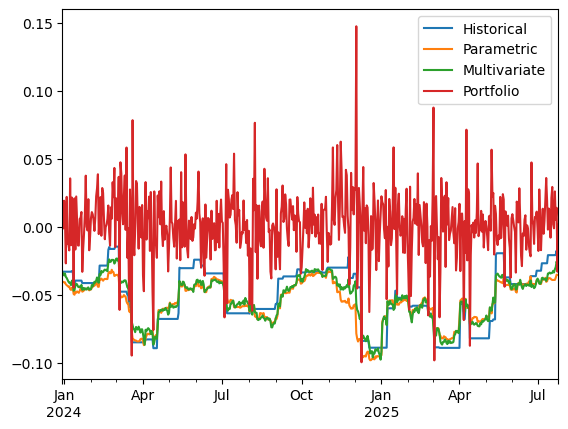

In [144]:
var_data.plot()
plt.show()

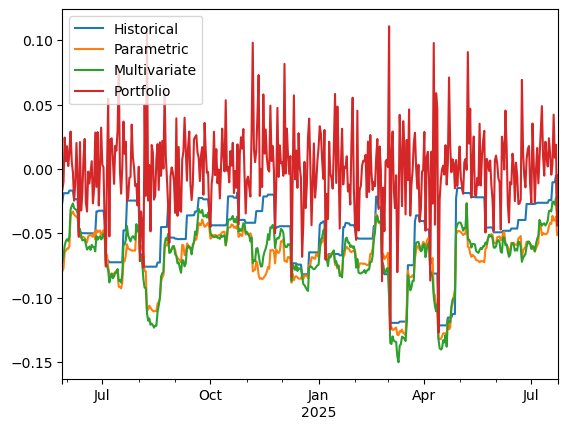

In [145]:
current_var_data.plot()
plt.show()


In [146]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.033159,0.019197,0.019197
Kupiec Stat,3.862919,14.806517,14.806517
P-value,0.049364,0.000119,0.000119


In [147]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.066194,0.018913,0.016548
Kupiec Stat,2.129053,11.170524,13.312288
P-value,0.14453,0.000831,0.000264


# Principal Component Analysis

## Historical PCA

In [150]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.57701473, 0.23465793, 0.07832473, 0.06079299, 0.04920961])

In [151]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

ADAUSDT      0.062605
AVAXUSDT     0.062509
BCHUSDT      0.047675
BNBUSDT      0.027517
BTCUSDT      0.032260
DOGEUSDT     0.064946
ETHUSDT      0.045347
HBARUSDT     0.062913
JASMYUSDT    0.072694
LINKUSDT     0.057496
LTCUSDT      0.043857
OMUSDT       0.073124
PAXGUSDT     0.000459
PEPEUSDT     0.083489
SOLUSDT      0.054983
SUIUSDT      0.060505
TRXUSDT      0.018691
USDCUSDT    -0.000164
WBTCUSDT     0.032033
XLMUSDT      0.049214
XRPUSDT      0.047847
Name: PC1, dtype: float64

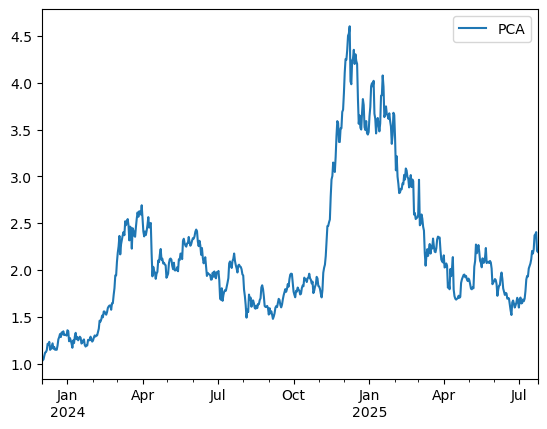

In [152]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()
plt.show()

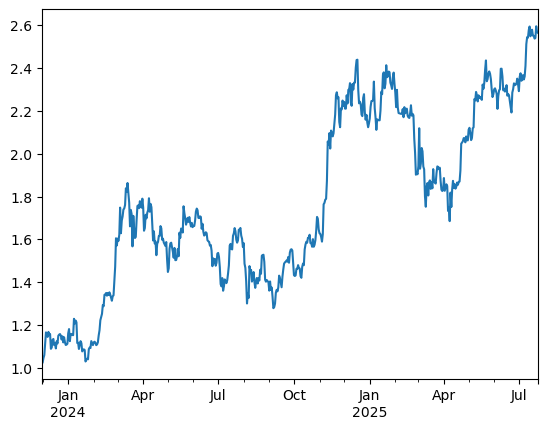

In [153]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [154]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances[:20]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.524503
WBTCUSDT     0.549498
BTCUSDT      0.550041
AVAXUSDT     0.667783
SOLUSDT      0.673703
LINKUSDT     0.674057
DOGEUSDT     0.693977
LTCUSDT      0.710495
BNBUSDT      0.712924
ADAUSDT      0.725584
XRPUSDT      0.763080
BCHUSDT      0.828813
XLMUSDT      0.901485
USDCUSDT     0.943619
PAXGUSDT     0.957363
SUIUSDT      1.071176
TRXUSDT      1.075066
HBARUSDT     1.095530
JASMYUSDT    1.211528
dtype: float64

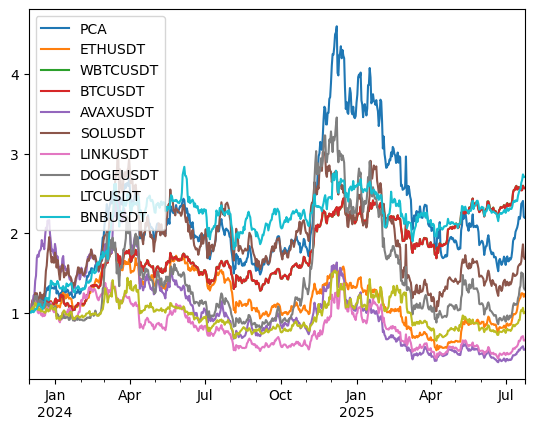

In [155]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()

<Axes: >

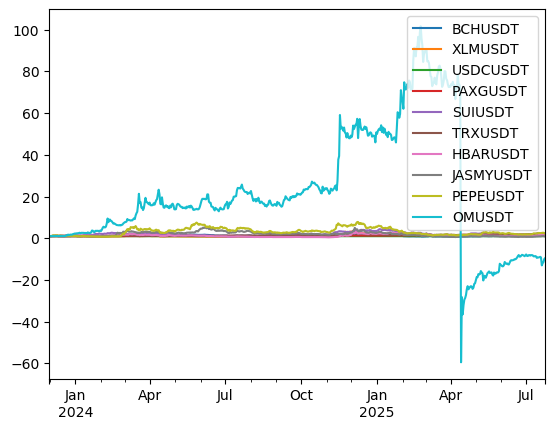

In [156]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [158]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.52242403, 0.30628311, 0.06921192, 0.0597288 , 0.04235215])

In [159]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

BTCUSDT      0.049478
SOLUSDT      0.091685
ETHUSDT      0.079377
JASMYUSDT    0.139696
TRXUSDT      0.034926
OMUSDT       0.253270
BBUSDT       0.164439
BNBUSDT      0.050367
PEPEUSDT     0.135859
PAXGUSDT     0.000903
Name: PC1, dtype: float64

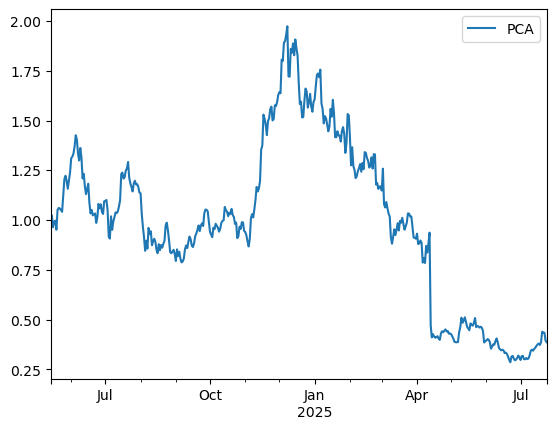

In [160]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()
plt.show()

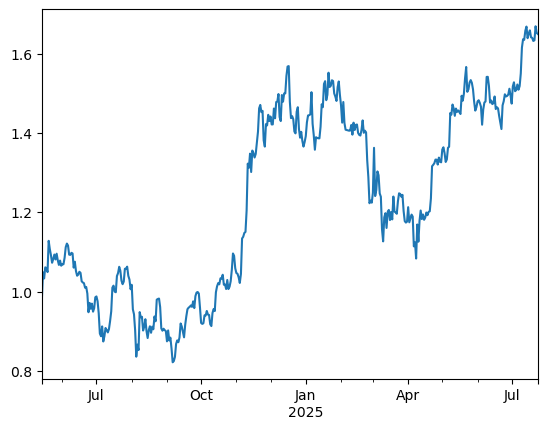

In [161]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()
plt.show()


In [162]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

C:\Users\Admin\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:86: FutureWarning: The behavior of DataFrame.sum with axis=None is deprecated, in a future version this will reduce over both axes and return a scalar. To retain the old behavior, pass axis=0 (or do not pass axis)
  return reduction(axis=axis, out=out, **passkwargs)


PCA          0.000000
ETHUSDT      0.745244
SOLUSDT      0.784379
BTCUSDT      0.798245
BNBUSDT      0.802627
JASMYUSDT    0.988735
PEPEUSDT     1.023909
PAXGUSDT     1.051426
BBUSDT       1.051674
TRXUSDT      1.170673
dtype: float64

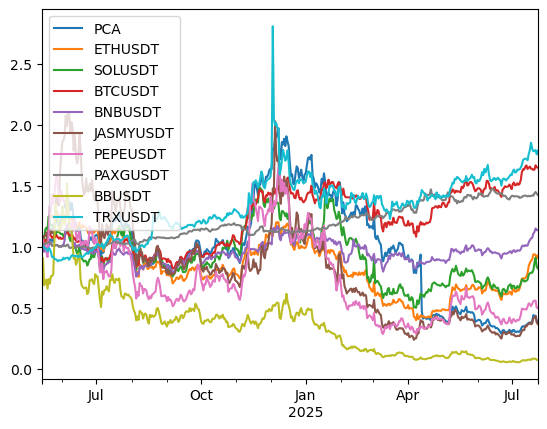

In [163]:
(1+comparison[distances.index[:10]]).cumprod().plot()
plt.show()


## Sensitivity Analysis

In [165]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.918269
BBUSDT       1.615054
JASMYUSDT    1.458064
SOLUSDT      1.279942
ETHUSDT      1.088065
BTCUSDT      1.000000
OMUSDT       0.985485
BNBUSDT      0.659869
TRXUSDT      0.330787
PAXGUSDT     0.028080
Name: BTCUSDT, dtype: float64

In [166]:
days=30
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

BBUSDT       2.582538
PEPEUSDT     2.298097
JASMYUSDT    1.822067
SOLUSDT      1.296335
OMUSDT       1.225078
ETHUSDT      1.136304
BTCUSDT      1.000000
BNBUSDT      0.544465
TRXUSDT      0.394764
PAXGUSDT     0.035365
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [168]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [169]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table.sort_values(by='Beta',ascending=False)

,Beta
BTCUSDT,0.484955
JASMYUSDT,0.289196
TRXUSDT,0.282901
ETHUSDT,0.241069
SOLUSDT,0.171302
BBUSDT,0.120780
OMUSDT,0.096435
PEPEUSDT,-0.100258
PAXGUSDT,-0.270167
BNBUSDT,-0.321658


### Regression to PCA

In [171]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-30:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

1.5571298488198386

In [172]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BTCUSDT      1.307766
BNBUSDT      1.127599
PCA          1.000000
ETHUSDT      0.874344
SOLUSDT      0.723313
JASMYUSDT    0.461200
PEPEUSDT     0.452841
BBUSDT       0.381126
TRXUSDT      0.284510
PAXGUSDT     0.219617
OMUSDT       0.158632
dtype: float64

In [173]:
reg=ex_ante_perf.copy().dropna().iloc[-30:]
reg['PCA']=historical_PCA

(reg.cov()['PCA']/reg.var()).sort_values(ascending=False)

BNBUSDT      2.084618
BTCUSDT      1.616388
PCA          1.000000
ETHUSDT      0.940667
TRXUSDT      0.852566
SOLUSDT      0.689778
JASMYUSDT    0.587501
PEPEUSDT     0.574780
BBUSDT       0.408579
OMUSDT       0.243481
PAXGUSDT    -0.004306
dtype: float64

### Correlation Matrix

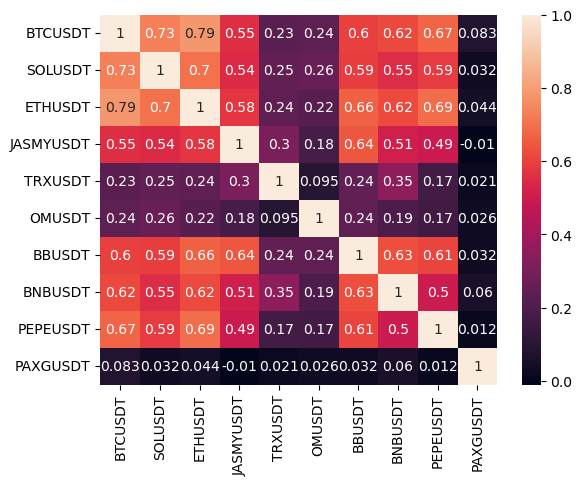

In [175]:
sns.heatmap(ex_ante_perf.corr(),annot=True)
plt.show()


<Axes: >

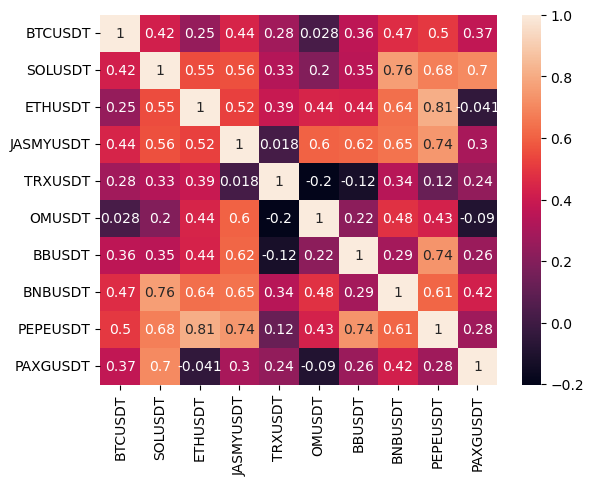

In [176]:
sns.heatmap(ex_ante_perf.iloc[-15:].corr(),annot=True)

In [177]:
gold=get_close(['SPY','GOLD.PA'],start=start_date.strftime("%Y-%m-%d"),end=enddate.strftime("%Y-%m-%d")).dropna()
gold.index=pd.to_datetime(gold.index)
pct_change=gold.pct_change().sort_index()

In [178]:
correlation=pct_change['GOLD.PA'].rolling(30).corr(pct_change['SPY']).dropna()
beta=(pct_change['GOLD.PA'].rolling(30).cov(pct_change['SPY']).dropna()/pct_change['SPY'].rolling(30).var().dropna())

<Axes: >

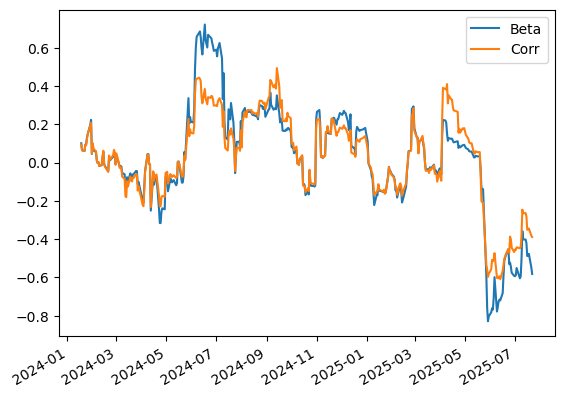

In [179]:
info=pd.DataFrame()
info['Beta']=beta
info['Corr']=correlation

info.plot()

## Sliding window optimization

In [ ]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

In [ ]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

In [ ]:
rolling_optimization.iloc[-1].sort_values(ascending=False)[:6]

In [ ]:
git.create_or_replace_notebook("Prod.ipynb")